Preprocessing of Weather Data - Clustering using a simple KMeans approach


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.impute import KNNImputer

In [38]:
data = pd.read_csv('..\..\Data\weatherAUS.csv')

data.head()
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           145460 non-null  object 
 1   Location       145460 non-null  object 
 2   MinTemp        143975 non-null  float64
 3   MaxTemp        144199 non-null  float64
 4   Rainfall       142199 non-null  float64
 5   Evaporation    82670 non-null   float64
 6   Sunshine       75625 non-null   float64
 7   WindGustDir    135134 non-null  object 
 8   WindGustSpeed  135197 non-null  float64
 9   WindDir9am     134894 non-null  object 
 10  WindDir3pm     141232 non-null  object 
 11  WindSpeed9am   143693 non-null  float64
 12  WindSpeed3pm   142398 non-null  float64
 13  Humidity9am    142806 non-null  float64
 14  Humidity3pm    140953 non-null  float64
 15  Pressure9am    130395 non-null  float64
 16  Pressure3pm    130432 non-null  float64
 17  Cloud9am       89572 non-null

Encode wind directions to angle

In [39]:
direction_to_angle = {'N': 0, 'NNE': np.pi/8, 'NE': (np.pi*2)/8, 'ENE': (np.pi*3)/8, 
                      'E': (np.pi*4)/8, 'ESE': (np.pi*5)/8, 'SE': (np.pi*6)/8, 'SSE': (np.pi*7)/8,
                      'S': np.pi, 'SSW': (np.pi*9)/8, 'SW': (np.pi*10)/8, 'WSW': (np.pi*11)/8,
                      'W': (np.pi*12)/8, 'WNW': (np.pi*13)/8, 'NW': (np.pi*14)/8, 'NNW': (np.pi*15)/8}
def circular_encode(direction):
    angle = direction_to_angle[direction]
    return np.sin(angle), np.cos(angle)

In [40]:
data['WindGustDir_x'] = data['WindGustDir'].apply(lambda x: circular_encode(x)[1] if(pd.notnull(x)) else x)
data['WindGustDir_y'] = data['WindGustDir'].apply(lambda x: circular_encode(x)[0] if(pd.notnull(x)) else x)

data['WindDir9am_x'] = data['WindDir9am'].apply(lambda x: circular_encode(x)[1] if(pd.notnull(x)) else x)
data['WindDir9am_y'] = data['WindDir9am'].apply(lambda x: circular_encode(x)[0] if(pd.notnull(x)) else x)

data['WindDir3pm_x'] = data['WindDir3pm'].apply(lambda x: circular_encode(x)[1] if(pd.notnull(x)) else x)
data['WindDir3pm_y'] = data['WindDir3pm'].apply(lambda x: circular_encode(x)[0] if(pd.notnull(x)) else x)

In [41]:
#drop 'old' variables of wind direction
#drop missing values of target variable
data = data.drop(['WindGustDir', 'WindDir9am', 'WindDir3pm'], axis = 1)


In [42]:
data = data.replace({'Yes': 1, 'No': 0})

Treatment of missing values

In [43]:
#replace the missing values before the highest three values of evaporation
#find the rows with the highest value in Evaporation to replace outliers and the NaNs before them by the mean.
print(data.sort_values(by = 'Evaporation').dropna(subset = ['Evaporation']).tail(10))
#The ids with the four highest Evaporation (over 80) are 42358, 8831, 106968, 105935.
evap_list_1 = list(range(42339, 42359))
print(data.loc[evap_list_1])

evap_list_2 = list(range(8819, 8832))
print(data.loc[evap_list_2])

evap_list_3 = list(range(106964, 106969))
print(data.loc[evap_list_3])

evap_list_4 = list(range(105930, 105936))
print(data.loc[evap_list_4])




              Date       Location  MinTemp  MaxTemp  Rainfall  Evaporation  \
107599  2014-10-28        Woomera     11.0     26.7       0.0         68.8   
105949  2010-01-23        Woomera     17.0     33.1       0.0         70.0   
107968  2015-11-01        Woomera     21.0     34.2       0.0         70.4   
105965  2010-02-08        Woomera     25.7     39.7       0.0         72.2   
23954   2017-01-03  NorfolkIsland     19.4     26.1       0.0         74.8   
107290  2013-12-23        Woomera     14.4     27.2       3.0         77.3   
105935  2010-01-09        Woomera     26.6     41.7       0.0         81.2   
106968  2013-01-07        Woomera     24.6     45.3       0.0         82.4   
8831    2016-11-11          Cobar     19.1     35.3       0.0         86.2   
42358   2016-12-19    Williamtown     15.3     23.9      58.2        145.0   

        Sunshine  WindGustSpeed  WindSpeed9am  WindSpeed3pm  ...  Temp9am  \
107599       NaN           33.0          24.0          19.0  ...

In [44]:
print('Before the value 145 in row 42358 there are 18 NaN, i. e. the mean becomes', round(145/19,1))
print('Before the value 86.2 in row 8831 there are 11 NaN, i. e. the mean becomes', round(86.2/12, 1))
print('Before the value 82.4 in row 106968 there are 3 NaN, i. e. the mean becomes', round(82.4/4, 1))
print('Before the value 81.2 in row 105935 there are 4 NaN, i. e. the mean becomes', round(81.2/5, 1))

Before the value 145 in row 42358 there are 18 NaN, i. e. the mean becomes 7.6
Before the value 86.2 in row 8831 there are 11 NaN, i. e. the mean becomes 7.2
Before the value 82.4 in row 106968 there are 3 NaN, i. e. the mean becomes 20.6
Before the value 81.2 in row 105935 there are 4 NaN, i. e. the mean becomes 16.2


In [45]:
data.loc[evap_list_1[1:], 'Evaporation']= round(145/19, 1)
data.loc[evap_list_2[1:], 'Evaporation']= round(86.2/12, 1)
data.loc[evap_list_3[1:], 'Evaporation']= round(82.4/4, 1)
data.loc[evap_list_4[1:], 'Evaporation']= round(81.2/5, 1)

In [46]:
print(data.sort_values(by = 'Evaporation').dropna(subset = ['Evaporation']).tail(10))

              Date       Location  MinTemp  MaxTemp  Rainfall  Evaporation  \
14616   2016-03-23          Moree     14.3     31.0       5.8         65.4   
8845    2016-11-25          Cobar      8.0     28.0       0.4         65.8   
108390  2016-12-27        Woomera     22.2     31.5       4.8         67.2   
107599  2014-10-28        Woomera     11.0     26.7       0.0         68.8   
107668  2015-01-05        Woomera     21.5     38.3       0.0         68.8   
105949  2010-01-23        Woomera     17.0     33.1       0.0         70.0   
107968  2015-11-01        Woomera     21.0     34.2       0.0         70.4   
105965  2010-02-08        Woomera     25.7     39.7       0.0         72.2   
23954   2017-01-03  NorfolkIsland     19.4     26.1       0.0         74.8   
107290  2013-12-23        Woomera     14.4     27.2       3.0         77.3   

        Sunshine  WindGustSpeed  WindSpeed9am  WindSpeed3pm  ...  Temp9am  \
14616       11.2           31.0          17.0           9.0  ...

In [47]:
#drop missing values of target variable
data = data.dropna(subset = ['RainTomorrow'])

KNN Imputation of missing values

In [48]:
#prepare data for knn imputation and run knn imputation
data_for_imputation = data.drop(['Location', 'Date'], axis = 1)

imputer = KNNImputer(n_neighbors=5)
data_imputed = imputer.fit_transform(data_for_imputation)

In [52]:
#turn imuted data into dataframe, add date and location back in and restore columns from data_for_imputation
data_imputed = pd.DataFrame(data_imputed)
#data_imputed.columns=data_for_imputation.columns
data_imputed.columns = data_for_imputation.columns
data_imputed.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 142193 entries, 0 to 142192
Data columns (total 24 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   MinTemp        142193 non-null  float64
 1   MaxTemp        142193 non-null  float64
 2   Rainfall       142193 non-null  float64
 3   Evaporation    142193 non-null  float64
 4   Sunshine       142193 non-null  float64
 5   WindGustSpeed  142193 non-null  float64
 6   WindSpeed9am   142193 non-null  float64
 7   WindSpeed3pm   142193 non-null  float64
 8   Humidity9am    142193 non-null  float64
 9   Humidity3pm    142193 non-null  float64
 10  Pressure9am    142193 non-null  float64
 11  Pressure3pm    142193 non-null  float64
 12  Cloud9am       142193 non-null  float64
 13  Cloud3pm       142193 non-null  float64
 14  Temp9am        142193 non-null  float64
 15  Temp3pm        142193 non-null  float64
 16  RainToday      142193 non-null  float64
 17  RainTomorrow   142193 non-nul

In [54]:
data_imputed.to_csv('..\..\Data\weatherAUS_imputed_Caro.csv', index = False)


In [55]:
data_imputed = pd.read_csv("..\..\Data\weatherAUS_imputed_Caro.csv")

In [56]:
data_imputed[['Date', 'Location']] = data.reset_index(drop=True)[['Date', 'Location']]
print(data_imputed.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 142193 entries, 0 to 142192
Data columns (total 26 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   MinTemp        142193 non-null  float64
 1   MaxTemp        142193 non-null  float64
 2   Rainfall       142193 non-null  float64
 3   Evaporation    142193 non-null  float64
 4   Sunshine       142193 non-null  float64
 5   WindGustSpeed  142193 non-null  float64
 6   WindSpeed9am   142193 non-null  float64
 7   WindSpeed3pm   142193 non-null  float64
 8   Humidity9am    142193 non-null  float64
 9   Humidity3pm    142193 non-null  float64
 10  Pressure9am    142193 non-null  float64
 11  Pressure3pm    142193 non-null  float64
 12  Cloud9am       142193 non-null  float64
 13  Cloud3pm       142193 non-null  float64
 14  Temp9am        142193 non-null  float64
 15  Temp3pm        142193 non-null  float64
 16  RainToday      142193 non-null  float64
 17  RainTomorrow   142193 non-nul

Prepare Data for clustering using simple KMeans approach

In [57]:
#drop target variables for clustering
data_for_clustering = data_imputed.drop('RainTomorrow', axis=1)

In [ ]:
# Elbow Method to find optimal k value
wcss = []
max_clusters = 10
for i in range(1, max_clusters+1):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(data_for_clustering_imputed)
    wcss.append(kmeans.inertia_)

In [58]:
# Group the data by 'Location'

grouped_data = data_for_clustering.groupby('Location')

# Initialize an empty DataFrame to store the clustered results
clustered_data = pd.DataFrame()

# Apply KMeans clustering to each group and append the results to 'clustered_data'
for location, group in grouped_data:
    # Extract features for clustering
    features = group[['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine',
       'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am',
       'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm',
       'Temp9am', 'Temp3pm', 'RainToday', 'WindGustDir_x', 'WindGustDir_y',
       'WindDir9am_x', 'WindDir9am_y', 'WindDir3pm_x', 'WindDir3pm_y']]
    
    # Apply KMeans clustering
    kmeans = KMeans(n_clusters=5) 
    group['Cluster'] = kmeans.fit_predict(features)
    
    # Append the clustered data for this location to 'clustered_data'
    clustered_data = pd.concat([clustered_data, group], ignore_index=True)

# Now 'clustered_data' contains the original data with an additional 'Cluster' column
# representing the cluster labels for each location


c:\Users\carop\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\carop\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py:110: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\carop\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 217, in _count_physical_cores
    raise ValueError(
c:\Users\carop\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the 

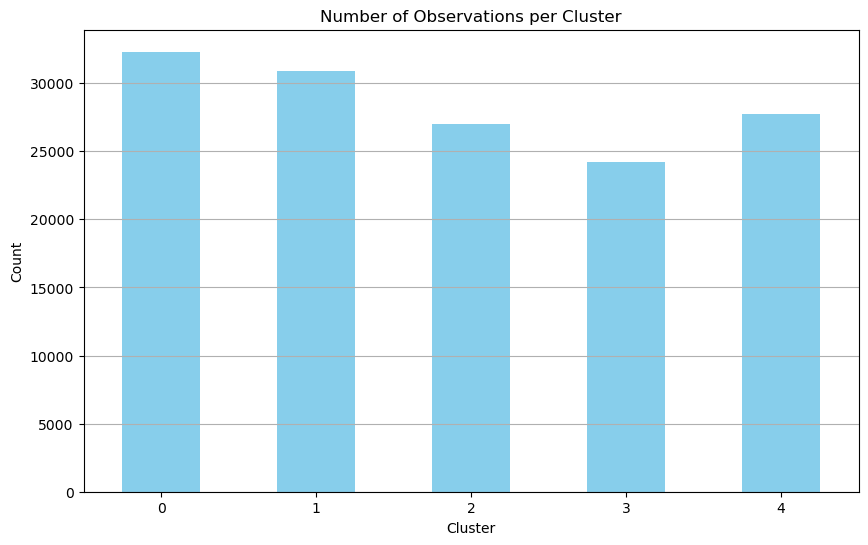

In [59]:
# Plot the number of observations per cluster
plt.figure(figsize=(10, 6))
clustered_data['Cluster'].value_counts().sort_index().plot(kind='bar', color='skyblue')
plt.title('Number of Observations per Cluster')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.show()

In [65]:
#add target variable back into clustered_data
clustered_data['RainTomorrow'] = data_imputed['RainTomorrow']
clustered_data.to_csv('..\..\Data\weatherAUS_imp_clustered_caro.csv', index = False)

In [61]:
print(clustered_data['RainTomorrow'].value_counts())


RainTomorrow
0.0    110316
1.0     31877
Name: count, dtype: int64


Add location coordinates to plot spatial data / visualize clusters

In [62]:
location_coordinates = {
    'Albury': (-36.080477, 146.91628),
    'BadgerysCreek': (-33.88649, 150.75229),
    'Cobar': (-31.49455, 145.83874),
    'CoffsHarbour': (-30.29624, 153.11349),
    'Moree': (-29.46354, 149.84168),
    'Newcastle': (-32.92667, 151.77835),
    'NorahHead': (-33.28141, 151.56871),
    'NorfolkIsland': (-29.03278, 167.94807),
    'Penrith': (-33.75899, 150.70895),
    'Richmond': (-33.59806, 150.74857),
    'Sydney': (-33.8548157, 151.2164539),
    'SydneyAirport': (-33.93992, 151.17527),
    'WaggaWagga': (-35.115, 147.36777),
    'Williamtown': (-32.79996, 151.84984),
    'Wollongong': (-34.424, 150.89359),
    'Canberra': (-35.29759, 149.10127),
    'Tuggeranong': (-35.42445, 149.08884),
    'MountGinini': (-35.5298, 148.7728),
    'Ballarat': (-37.56014, 143.8585),
    'Bendigo': (-36.75818, 144.28264),
    'Sale': (-38.10964, 147.06872),
    'MelbourneAirport': (-37.67277, 144.84916),
    'Melbourne': (-37.8142176, 144.9631608),
    'Mildura': (-34.18385, 142.1625),
    'Nhil': (-36.33276, 141.64856),
    'Portland': (-38.34682, 141.60494),
    'Watsonia': (-37.71114, 145.0821),
    'Dartmoor': (-37.92047, 141.27501),
    'Brisbane': (-27.4689682, 153.0234991),
    'Cairns': (-16.92056, 145.77278),
    'GoldCoast': (-28.01667, 153.39999),
    'Townsville': (-19.25896, 146.81694),
    'Adelaide': (-34.928661, 138.598633),
    'MountGambier': (-37.8247, 140.78275),
    'Nuriootpa': (-34.46617, 138.99516),
    'Woomera': (-31.19989, 136.82536),
    'Albany': (-35.02378, 117.88361),
    'Witchcliffe': (-34.03024, 115.09834),
    'PearceRAAF': (-31.66766, 116.01955),
    'PerthAirport': (-31.94375, 115.96694),
    'Perth': (-31.9527121, 115.8604796),
    'SalmonGums': (-32.98058, 121.63985),
    'Walpole': (-34.97985, 116.73276),
    'Hobart': (-42.88251, 147.32812),
    'Launceston': (-41.42982, 147.15735),
    'AliceSprings': (-23.70021, 133.88119),
    'Darwin': (-12.46113, 130.84185),
    'Katherine': (-14.46407, 132.2639),
    'Uluru': (-25.34544, 131.03688)
}

# Create new columns for latitude and longitude
clustered_data['Latitude'] = clustered_data['Location'].map(lambda x: location_coordinates[x][0] if x in location_coordinates else None)
clustered_data['Longitude'] = clustered_data['Location'].map(lambda x: location_coordinates[x][1] if x in location_coordinates else None)



In [63]:
clustered_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 142193 entries, 0 to 142192
Data columns (total 29 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   MinTemp        142193 non-null  float64
 1   MaxTemp        142193 non-null  float64
 2   Rainfall       142193 non-null  float64
 3   Evaporation    142193 non-null  float64
 4   Sunshine       142193 non-null  float64
 5   WindGustSpeed  142193 non-null  float64
 6   WindSpeed9am   142193 non-null  float64
 7   WindSpeed3pm   142193 non-null  float64
 8   Humidity9am    142193 non-null  float64
 9   Humidity3pm    142193 non-null  float64
 10  Pressure9am    142193 non-null  float64
 11  Pressure3pm    142193 non-null  float64
 12  Cloud9am       142193 non-null  float64
 13  Cloud3pm       142193 non-null  float64
 14  Temp9am        142193 non-null  float64
 15  Temp3pm        142193 non-null  float64
 16  RainToday      142193 non-null  float64
 17  WindGustDir_x  142193 non-nul

In [64]:
import plotly.express as px


# Plotly scatter_geo plot of locations colored by clusters
fig = px.scatter_geo(clustered_data, lat='Latitude', lon='Longitude', color='Cluster', hover_name='Cluster')
fig.update_geos(projection_type="mercator", showcoastlines=True, coastlinecolor="darkgray", showland=True, landcolor="lightgray")
fig.update_layout(title="Locations Colored by Clusters", geo=dict(center=dict(lat=-25, lon=133), 
                                                                  lataxis_range=[-45, -5], lonaxis_range=[110, 160]))
fig.show()